<a href="https://colab.research.google.com/github/mantoan-thi/Machine-Learning-Projects-with-Python/blob/main/Analise_defeitos_Yzk_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning: Séries temporais e PMDARIMA (Autoarima)

In [ ]:
!pip install pmdarima

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [47]:
df = pd.read_csv('/content/defeitos.csv',sep=';',encoding='latin-1')
df['Data'] = pd.to_datetime(df['Data'])
df.head(2)

,Data,Turno,Linha,Projeto,Cliente,Processo,Código defeito,Classificação,Descrição do defeito,Ramal,Cavidade,Defeitos,QTD INSP
0,2020-06-01,A,IP T5/TR,T5/TR,HONDA,Inspeção final,u1,S,Tubo com Circuitos VisÍveis ( CVO / COT / ZIPER ),60,NaN,1,NaN
1,2020-06-01,A,IP T5/TR,T5/TR,HONDA,Inspeção final,T1,B,Ramal / Saída em Posição Errada,36,NaN,1,NaN


In [48]:
df['Linha'].unique()

array(['IP T5/TR', 'L Cabin T5/TR', 'R Cabin T5/TR', 'IP T9',
       'L Cabin T9', 'R Cabin T9', 'Floor T5/TR', '360B ERM', '833W ERM',
       '474B ERM', '474B IP FLOOR', '360B SMALL', '360B ENG', '360B DOOR',
       '740B DOOR RH', 'L CABIN T9', 'R CABIN T9', '740B SMALL',
       'IP TRYX ', 'Floor TRYX ', 'L Cabin TRYX ', 'R Cabin TRYX ',
       'R Cabin T9LT ', 'IP T9LT ', 'L Cabin T9LT ', 'L Cabin T5NR ',
       'R Cabin T5NR ', 'Floor T5NR ', 'IP T5NR ', '740B ENG', '740B ERM',
       '740B BACK DOOR', '740B DOOR LH', 'Bateria T9LT ', '360B Eng',
       'AS DOOR 752 T00A', 'DR DOOR 751 T00A', 'FLOOR 4DR T00A',
       'ERM T00A', 'RR_L DOOR 754 T00A', 'RR_R DOOR 753 T00A',
       'ERM ARG T00A', 'FLOOR 5DR T00A'], dtype=object)

In [49]:
# Filtrando a linha e Turno

linha = '740B ERM'
Turno = 'A'

df_linha_turno = df.loc[df.Linha == linha]
df_linha_turno = df_linha_turno.loc[df_linha_turno.Turno == Turno]
df_linha_turno.head(2)

,Data,Turno,Linha,Projeto,Cliente,Processo,Código defeito,Classificação,Descrição do defeito,Ramal,Cavidade,Defeitos,QTD INSP
15753,2020-02-12,A,740B ERM,740B,TOYOTA,Inspeção final,B2,B,Amarre Auxiliar Faltante,2,NaN,1,NaN
15754,2020-02-12,A,740B ERM,740B,TOYOTA,Inspeção final,E8,A,Circuito Maior que Especificado,611,NaN,1,NaN


In [50]:
df_linha_turno = df_linha_turno.set_index('Data')
df_linha_turno.index = pd.to_datetime(df_linha_turno.index, format='%Y-%m-%d')
df_linha_turno = df_linha_turno[['Projeto','Defeitos']].groupby('Data').sum()
df_linha_turno.head(2)

,Defeitos
Data,
2020-02-12,17
2020-07-12,17


In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

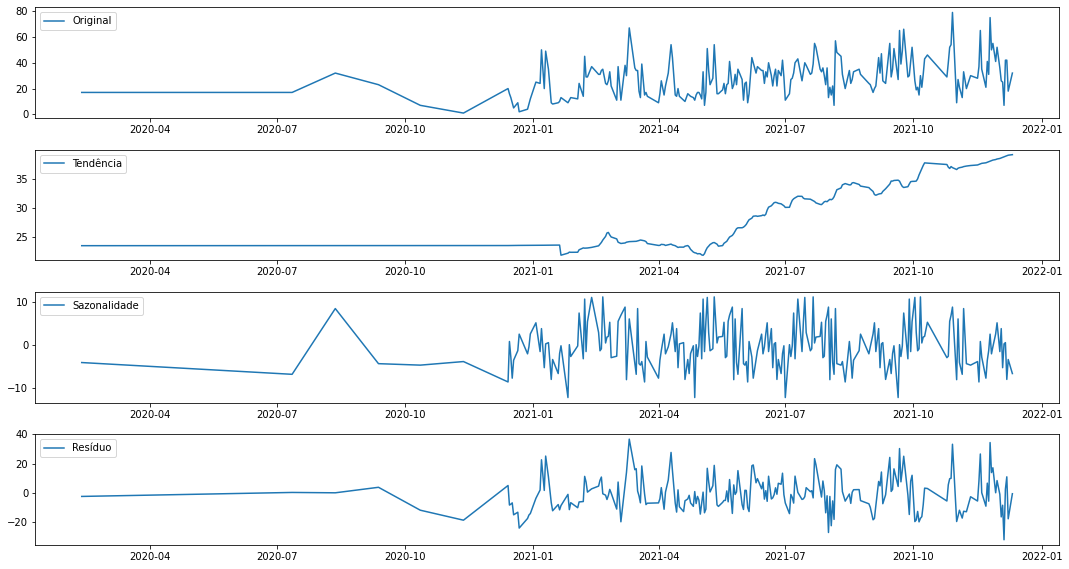

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_linha_turno,period=52,extrapolate_trend=52) 
trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 
plt.gcf().set_size_inches(15, 8)
plt.subplot(411) 
plt.plot(df_linha_turno, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Tendência') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Sazonalidade') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Resíduo') 
plt.legend(loc='best') 
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



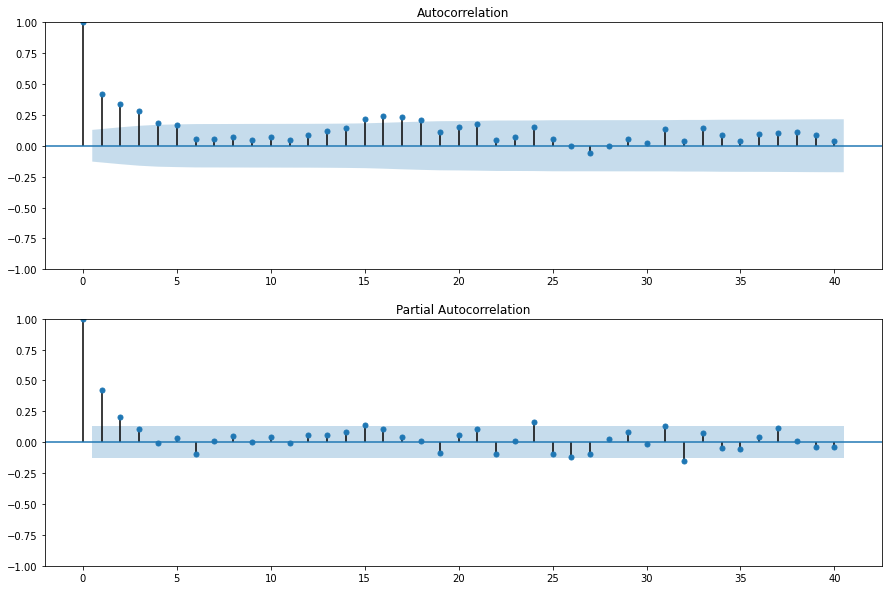

In [53]:
import statsmodels.api as sm
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
sm.graphics.tsa.plot_acf(df_linha_turno.values.squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_linha_turno.values.squeeze(), lags=40, ax=ax2)
plt.show();

No gráfico, o eixo vertical indica a autocorrelação e o horizontal a defasagem. A sombra em azul indica onde é significativamente diferente de zero. Como é possível ver na imagem, praticamente todos os valores ACF estão dentro do limite da sombra azul. Ou seja, autocorrelação igual a zero, indicando que a série é aleatória – conforme o esperado.

* ACF = autocorrelation function

Utilizando o pacote PMDARIMA (Autoarima)
O pacote pmdarima é utilizado para aplicar uma especie de força bruta em um modelo arima testando diversos parâmetros afim de encontrar o melhor cenário com baixo AIC. No entanto antes de começarmos vamos entender um pouco mais sobre o ARIMA.

Um modelo ARIMA significa Média Móvel integrada AutoRegressiva, ou seja este tipo de modelo trabalha com a Média Móvel diante de dados históricos para prever o futuro, diferente de alguns outros modelos o ARIMA suporta trabalhar tanto com dados sazonais como dados não sazonais, tudo isso é especificado através de uma série de parâmetros que basicamente categoriza seus dados em tendência,ruido e sazonalidade. Vamos discutir os parâmetros mais importantes do ARIMA o p,d e q.

Primeiramente o parâmetro P associado ao AR do modelo ARIMA, é o parâmetro de regressão dos dados, ou seja, é ele que procura entender como esta se comportando os dados do passado.

O segundo parâmetro D associado ao I do modelo ARIMA, é o parâmetro que busca identificar uma especie de “semelhança” nos dados, ou seja, a diferenciação entre os dados e com isso é possível saber se os dados tem uma grande variancia o que contribui com o cenário de previsão.

Por ultimo o parâmetro Q associado ao MA do modelo ARIMA, é o parâmetro da média móvel do modelo, em outras palavras ele que identificada através do calculo de média móvel a direção da tendência dos dados.

In [54]:
from pmdarima.arima import auto_arima
bruteforce_modelo = auto_arima(df_linha_turno, 
                               start_p=0, 
                               start_d=0 ,
                               start_q=0,
                               max_p=8, 
                               max_d=8,
                               max_q=8, 
                               m=7, 
                               start_P=0, 
                               seasonal=True, 
                               d=1, D=1, 
                               trace=True, 
                               error_action='ignore',
                               suppress_warnings=True, 
                               stepwise=False)

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2026.800, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=1969.450, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=1922.777, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1975.578, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1901.812, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.59 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=1860.982, Time=0.6

In [55]:
print(f"Resultado AIC: {bruteforce_modelo.aic()}")
print(f"Resultado melhores parametros (p,d,q): {bruteforce_modelo.order}")

Resultado AIC: 1860.981811054209
Resultado melhores parametros (p,d,q): (0, 1, 1)


In [56]:
futuro_forecast = bruteforce_modelo.predict(n_periods=30)

In [57]:
import datetime 
dataatual = datetime.datetime.today()
dataatual = datetime.datetime.today() - datetime.timedelta(days=1)
lista_datas = [dataatual + datetime.timedelta(days=x) for x in range(30)]
lista_datas = [pd.datetime.strftime(i,'%Y-%m-%d') for i in lista_datas]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [58]:
futuro_forecast = bruteforce_modelo.predict(n_periods=30)
futuro_forecast = pd.DataFrame(futuro_forecast,index = lista_datas,columns=['Defeitos'])
futuro_forecast.index.name = 'Data'
futuro_forecast.index = pd.to_datetime(futuro_forecast.index)
futuro_forecast.cases = round(futuro_forecast.Defeitos,0)
futuro_forecast.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



,Defeitos
Data,
2021-12-07,26.729132
2021-12-08,42.086569


In [59]:
final = pd.concat([df_linha_turno,futuro_forecast])
final.head(2)

,Defeitos
Data,
2020-02-12,17.0
2020-07-12,17.0


In [60]:
import plotly.graph_objects as go   
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_linha_turno.index, y=df_linha_turno.Defeitos,mode='lines+markers',
                    name='Atual'))

fig.add_trace(go.Scatter(x=futuro_forecast.index, y=futuro_forecast.Defeitos,mode='lines+markers', name='Previsto',
line=dict(dash='dashdot')))

fig.update_layout(title="Previsão para os proximos 30 dias de defeitos na linha", width=1200, height=600)
fig.show()

Testando nosso modelo.

In [61]:
dataatual = datetime.datetime.today()
dataatual = datetime.datetime.today() - datetime.timedelta(days=15)
lista_datas = [dataatual + datetime.timedelta(days=x) for x in range(15)]
lista_datas = [pd.datetime.strftime(i,'%Y-%m-%d') for i in lista_datas]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [62]:
lista_datas

['2021-11-23',
 '2021-11-24',
 '2021-11-25',
 '2021-11-26',
 '2021-11-27',
 '2021-11-28',
 '2021-11-29',
 '2021-11-30',
 '2021-12-01',
 '2021-12-02',
 '2021-12-03',
 '2021-12-04',
 '2021-12-05',
 '2021-12-06',
 '2021-12-07']

In [63]:
df_validacao = df_linha_turno.iloc[0:-14]

In [64]:
from pmdarima.arima import auto_arima
valid_model = auto_arima(df_validacao, start_p=0, start_d=0 ,start_q=0,max_p=8, max_d=8,max_q=8, m=7, start_P=0, seasonal=False, trace=True, error_action='ignore',suppress_warnings=True, stepwise=False)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1801.265, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1735.044, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1760.598, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1746.347, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1745.734, Time=0.18 sec

In [65]:
print(f"Resultado AIC: {valid_model.aic()}")
print(f"Resultado melhores parametros (p,d,q): {valid_model.order}")

Resultado AIC: 1735.044326976626
Resultado melhores parametros (p,d,q): (0, 1, 1)


In [66]:
valid_forecast = valid_model.predict(n_periods=15)
valid_forecast = pd.DataFrame(valid_forecast,index = lista_datas,columns=["Defeitos"])
valid_forecast.index.name = 'Data'
valid_forecast.index = pd.to_datetime(valid_forecast.index)
valid_forecast.Defeitos = round(valid_forecast.Defeitos,0)
valid_forecast.head(2)

,Defeitos
Data,
2021-11-23,36.0
2021-11-24,36.0


In [67]:
import plotly.graph_objects as go   
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_linha_turno.index, y=df_linha_turno.Defeitos,mode='lines+markers',
                    name='Atual'))

fig.add_trace(go.Scatter(x=valid_forecast.index, y=valid_forecast.Defeitos,mode='lines+markers', name='Validação 15 dias',
line=dict(dash='dashdot')))

fig.add_trace(go.Scatter(x=futuro_forecast.index, y=futuro_forecast.Defeitos,mode='lines+markers', name='Previsto 30 dias',
line=dict(dash='dashdot')))

fig.update_layout(title="Validando eficiência do modelo com dados ja existentes.", width=1200, height=600)
fig.show()

Conforme podemos observar a previsão de 15 dias seguiu uma tendencia e não a sazonalidade dos dados originais, enquanto a previsão de 30 dias que já visualizamos anteriormente considerou a sazonalidade.

#Machine learning nos defeitos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
df = pd.read_csv('/content/Dataset_qualidade.csv',sep=';',encoding='latin-1')
df.drop(columns=['Data','Turno', 'Linha', 'Projeto', 'Processo', 'Código_defeito',
       'Classificação', 'Descrição_do_defeito'],inplace=True)
df.head(2)

,Efetivo_operacional,Efetivo_poli,Qtde_faltas,Qtde_faltas_sub,Qtde_faltas_conveyor,Qtde_faltas_area_final,Alteração_na_linha,Faltas_no_turno_anterior,Temperatura,Dia_da_semana,Peças_por_hora,Takt_time,Tempo_standart,Qtde_ckt,Qtde_defeitos
0,58,2,3,0,1,2,0,1,30,2,"18,0","200,5369128","3,182392",251,1
1,60,4,2,0,0,2,1,1,29,2,"17,6","204,6575342","3,182392",251,2


In [3]:
df = df.replace({',': '.'}, regex=True)

In [4]:
df.describe()

,Efetivo_operacional,Efetivo_poli,Qtde_faltas,Qtde_faltas_sub,Qtde_faltas_conveyor,Qtde_faltas_area_final,Alteração_na_linha,Faltas_no_turno_anterior,Temperatura,Dia_da_semana,Qtde_ckt,Qtde_defeitos
count,35151.000000,35151.000000,35151.000000,35151.000000,35151.000000,35151.000000,35151.000000,35151.000000,35151.000000,35151.000000,35151.000000,35151.000000
mean,48.409064,2.415664,3.013257,1.006373,1.004182,1.002703,0.498421,0.498649,30.499104,4.191147,207.618702,1.038434
std,14.083804,1.183141,1.412037,0.813166,0.817525,0.816556,0.500005,0.500005,1.116356,1.538364,75.164999,0.327631
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,2.000000,5.000000,1.000000
25%,34.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,3.000000,167.000000,1.000000
50%,56.000000,2.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,30.000000,4.000000,251.000000,1.000000
75%,58.000000,3.000000,4.000000,2.000000,2.000000,2.000000,1.000000,1.000000,31.000000,5.000000,251.000000,1.000000
max,60.000000,4.000000,6.000000,2.000000,2.000000,2.000000,1.000000,1.000000,32.000000,7.000000,251.000000,18.000000


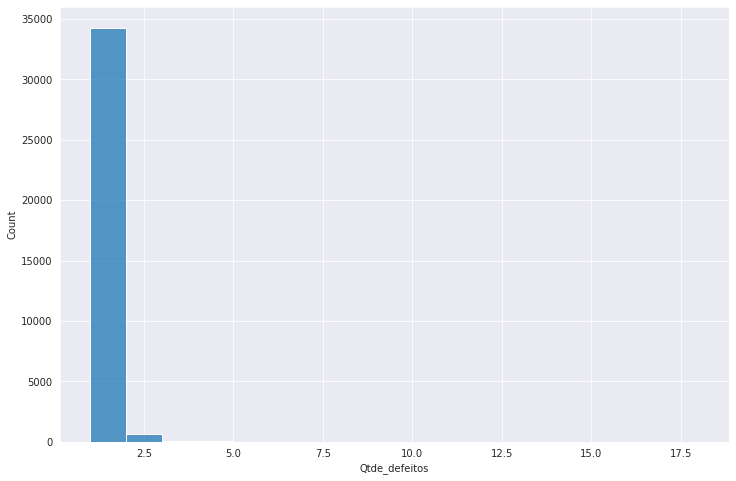

In [5]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.histplot(df.Qtde_defeitos)

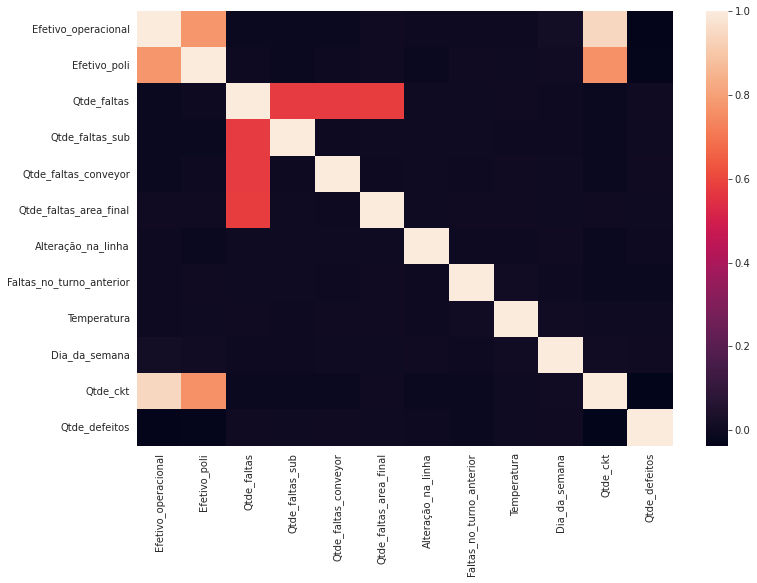

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr())

A nossa intenção e saber o grau de correlação das variáveis com a variável que queremos prever('Qtde_defeitos'), então podemos simplesmente filtrar a coluna com essas informações.

In [7]:
correlations = df.corr()
correlations['Qtde_defeitos']

Efetivo_operacional        -0.030215
Efetivo_poli               -0.026022
Qtde_faltas                 0.003511
Qtde_faltas_sub             0.001430
Qtde_faltas_conveyor        0.005667
Qtde_faltas_area_final     -0.001026
Alteração_na_linha         -0.001800
Faltas_no_turno_anterior   -0.006716
Temperatura                 0.002855
Dia_da_semana               0.004615
Qtde_ckt                   -0.037610
Qtde_defeitos               1.000000
Name: Qtde_defeitos, dtype: float64

Utilizando Machine Learning para realizar a previsão

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[0:,0:-1],df['Qtde_defeitos'], test_size=0.5, random_state=27)

In [9]:
lr = LinearRegression()
model = lr.fit(X_train,y_train)
resultado = model.predict(X_test)
mse = mean_squared_error(y_test, resultado)
scr = model.score(X_test,y_test)
print('MSE: ',round(mse,2))
print('Accuracy: {:.2%}'.format(scr))

MSE:  0.12
Accuracy: 0.08%


In [10]:
resultado_treino = model.predict(X_train)
mse_t  = mean_squared_error(y_train, resultado_treino)
scr_t = model.score(X_train,y_train)
print('MSE: ',round(mse_t,2))
print('Accuracy: {:.2%}'.format(scr_t))

MSE:  0.09
Accuracy: 0.21%


Nesse primeiro modelo temos um erro muito alto e um valor de score muito baixo, esses resultados não são nem um pouco satisfatórios.

Um dos motivos é que temos muitos dados binários no conjunto de dados (0 e 1), os modelos de regressão linear tendem a funcionar melhor quando temos dados numéricos contínuos.

Os modelos de árvore apresentam melhores resultados, vamos ver a seguir se essa premissa se confirma.

In [11]:
tree = DecisionTreeRegressor()
model_tree = tree.fit(X_train,y_train)
resultado_tree = tree.predict(X_test)
mse = mean_squared_error(y_test, resultado_tree)
scr = model_tree.score(X_test,y_test)
print('MSE: ',round(mse,2))
print('Accuracy: {:.2%}'.format(scr))

MSE:  0.31
Accuracy: -147.33%


In [12]:
tree_rf = RandomForestRegressor()
model_rf = tree_rf.fit(X_train, y_train)
resultado_rf = model_rf.predict(X_test)
mse = mean_squared_error(y_test, resultado_rf)
scr = model_rf.score(X_test,y_test)
print('MSE: ',round(mse,2))
print('Accuracy: {:.2%}'.format(scr))

MSE:  0.14
Accuracy: -13.17%


Ajustando os hiperparametros do Random Forest

In [13]:
from sklearn.model_selection import GridSearchCV

parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]}

rf = RandomForestRegressor()
grid = GridSearchCV(rf, parametros)
grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'min_samples_leaf': [1, 10],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 250, 500, 750]})

In [14]:
# Verificando os melhores parâmetros:
grid.best_params_

{'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 750}

In [15]:
# Recuperando o melhor estimator:
rf_best = grid.best_estimator_

In [16]:
# Gerando o resultado final:
resultado_final = rf_best.predict(X_test)
mse = mean_squared_error(y_test, resultado_final)
scr = rf_best.score(X_test,y_test)
print('MSE: ',round(mse,2))
print('Accuracy: {:.2%}'.format(scr))

MSE:  0.13
Accuracy: -0.80%


# Previsão de defeitos

In [2]:
!pip install squarify

In [29]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.6 MB/s 


In [1]:
import  plotly.express  as  px
import pandas as pd                           # Manipulação de dados
import glob                                   # Importação de dados
import re                                     # Expressões regulares
import itertools                              # Ferramenta iteração
import numpy as np                            # Computação científica
import statsmodels.api as sm                  # Modelagem estatística
import seaborn as sns                         # Visualização de dados
import squarify                               # Visualização de treemaps

import matplotlib.pyplot as plt               # Visualização de dados
import matplotlib
plt.style.use('fivethirtyeight') 

#import plotly.offline as py                   # Visualização de dados
#py.init_notebook_mode(connected=True)         # Offline plotly version
import plotly.graph_objs as go
import plotly.tools as tls                    # Ferramentas do plotly

import folium                                 # Visualização de mapas
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster

import warnings                               # Ignorar warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [11]:
# FUNÇÃO PARA IMPORTAR DATASET
df = pd.read_csv('/content/Dataset_qualidade.csv',sep=';',encoding='latin-1')

df = df[df['Turno']=='A']
df = df[df['Linha']=='360B ERM']


df.drop(columns=['Turno', 'Linha', 'Projeto', 'Processo', 'Código_defeito',
                 'Classificação', 'Descrição_do_defeito'],inplace=True)
df = df.replace({',': '.'}, regex=True)
df['Data']=pd.to_datetime(df['Data'])

In [12]:
ocorrencias = df.groupby('Data').count()['Qtde_defeitos'].reset_index()

fig  =  px.line(ocorrencias, x = "Data",y ='Qtde_defeitos', title = 'Quantidade de Defeitos' ) 
fig.show()

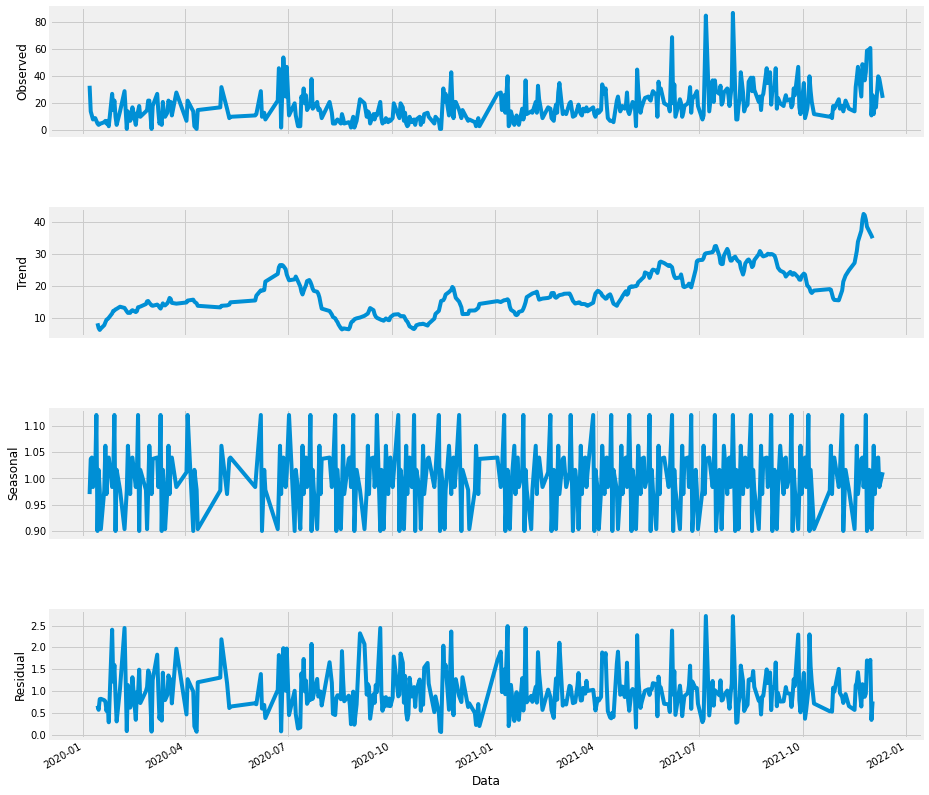

In [13]:
# TRANSFORMANDO SÉRIE TEMPORAL
ocorrencias = df.groupby('Data').count()['Qtde_defeitos'].reset_index()
ocorrencias.index =  ocorrencias.Data
ocorrencias.drop(columns='Data', inplace=True)
ocorrencias.index = pd.to_datetime(ocorrencias.index)

# IMPORTANDO BIBLIOTECAS

from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl


# DECOMPOSIÇÃO DA SÉRIE TEMPORAL

result = seasonal_decompose(ocorrencias, model='multiplicative',freq=12)
g = result.plot()
g.set_figwidth(14)
g.set_figheight(14)

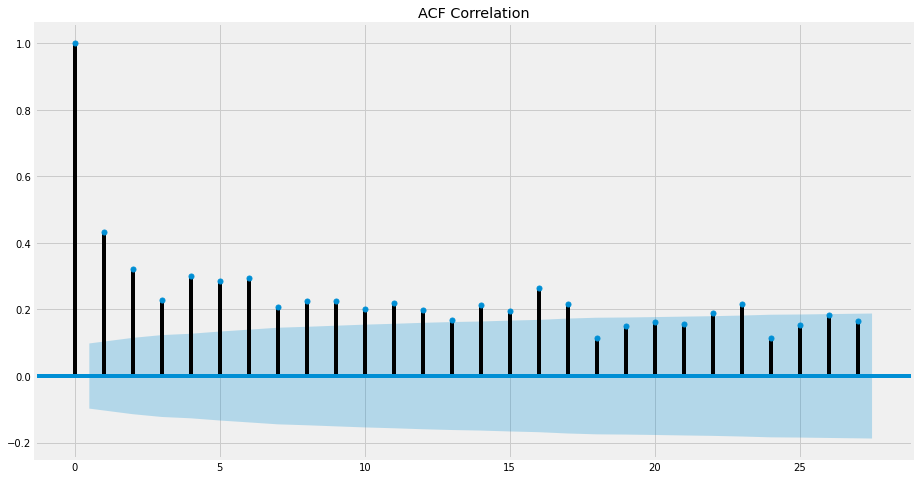

In [14]:
# IMPORTANDO BIBLIOTECAS

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# PLOT DE CORRELAÇÃO ACF

g = plot_acf(ocorrencias, title="ACF Correlation")
g.set_figheight(8)
g.set_figwidth(14)

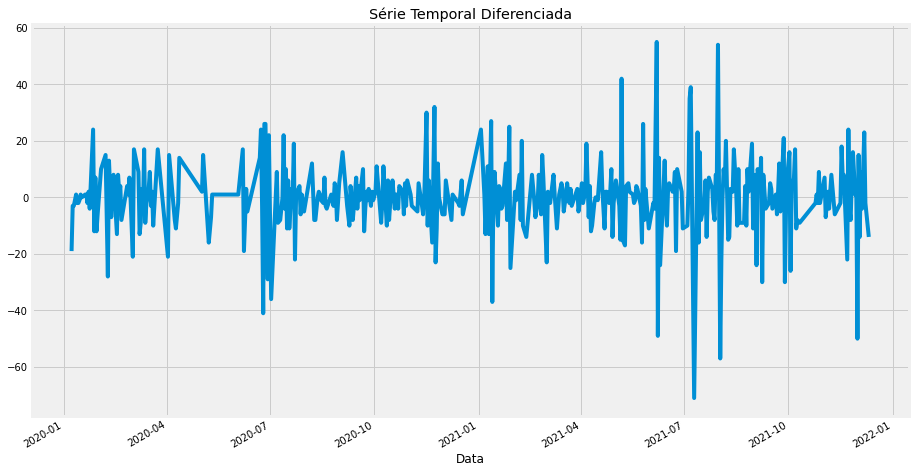

In [15]:
# DIFERENCIANDO SÉRIE TEMPORAL

ocorrencias_diff = ocorrencias.diff(periods=1)
ocorrencias_diff = ocorrencias_diff[1:]

# PLOT DA SÉRIE TEMPORAL DIFERENCIADA COM D = 1

g = ocorrencias_diff.plot(figsize=(14,8), title="Série Temporal Diferenciada", legend=False)

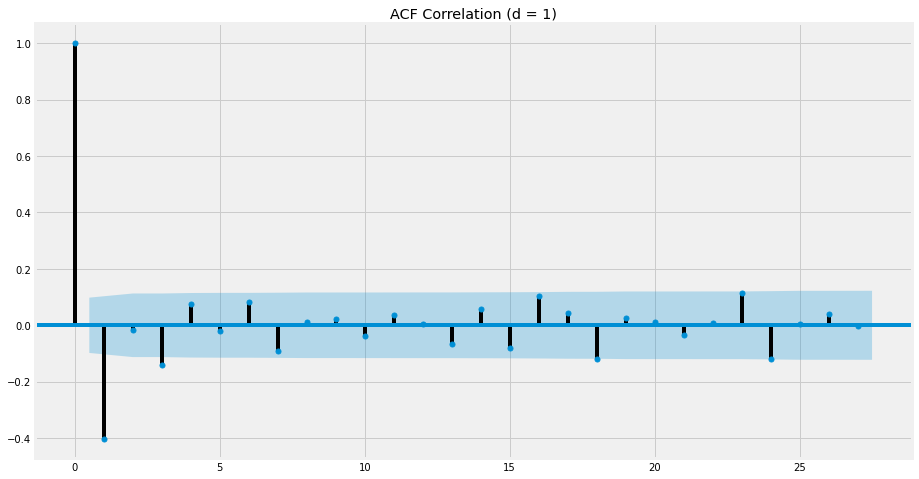

In [16]:
# PLOT CORRELAÇÃO ACF

g = plot_acf(ocorrencias_diff, title="ACF Correlation (d = 1)")
g.set_figheight(8)
g.set_figwidth(14)

Melhoers parâmetros:  ((3, 1, 13), (2, 1, 3, 12))  AUC:  2630.4029232840767


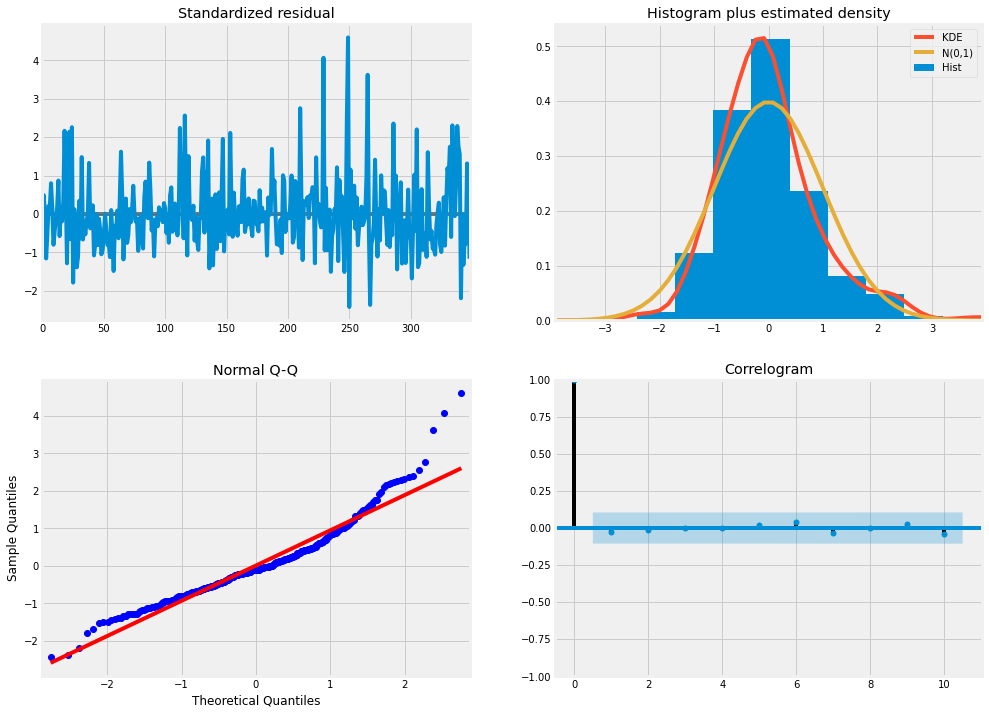

In [17]:
# DEFINE COMBINAÇÕES ENTRE p DE 0 A 3, d = 1, e q = 13
pdq = [(p, 1, 13) for p in range(0, 4)]

# DEFINE P e Q ENTRE 0 e 3
P = Q = range(0, 4)

# DEFINE COMBINAÇÕES ENTRE P, D e Q
seasonal_pdq = [(x[0], 1, x[1], 12) for x in list(itertools.product(P, Q))]

# CALCULANDO O MELHOR PARÂMETRO PARA O MODELO

scores = {}

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ocorrencias,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            scores[param, param_seasonal] = results.aic
            
        except:
            continue
            
print("Melhoers parâmetros: ", min(scores, key=scores.get)," AUC: ", min(scores.values()))

# CRIANDO MODELO COM OS MELHOERS PARÂMETROS 

mod = sm.tsa.statespace.SARIMAX(ocorrencias,
                                order=(3, 1, 13),
                                seasonal_order=(3, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

# RESUMO DO MODELO

results.plot_diagnostics(figsize=(15, 12))
plt.show()

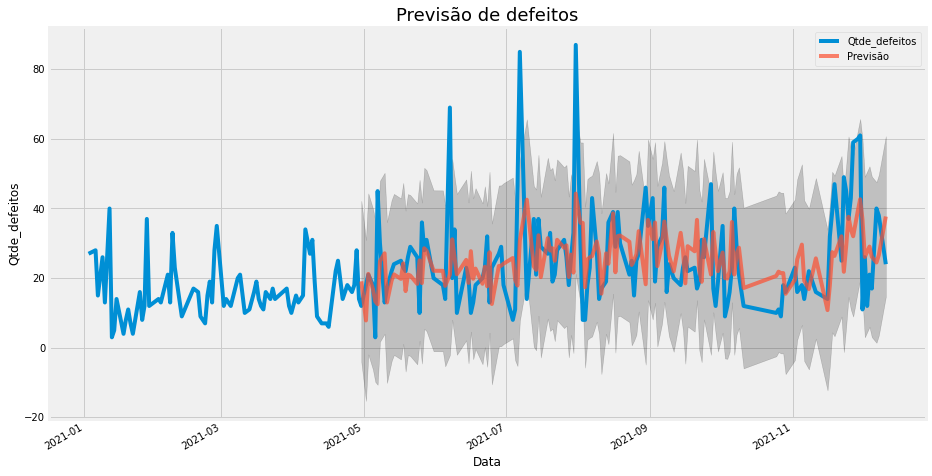

O Mean Squared Error da previsão foi 178


In [18]:
# VALIDAÇÃO DO MODELO: PREVENDO OCORRÊNCIAS A PARTIR DE 2017

pred = results.get_prediction(start=pd.to_datetime('2021-04-30'), dynamic=False)

pred_ci = pred.conf_int()

ax = ocorrencias['2021':].plot(figsize=(14, 8))
pred.predicted_mean.plot(ax=ax, label='Previsão', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_title("Previsão de defeitos", fontsize=18)
ax.set_xlabel('Data')
ax.set_ylabel('Qtde_defeitos')
plt.legend()

plt.show()

# CALCULANDO MSE

y_forecasted = pred.predicted_mean
y_truth = ocorrencias["2021-04-30":].squeeze()

mse = ((y_forecasted - y_truth) ** 2).mean()

print('O Mean Squared Error da previsão foi {}'.format(round(mse)))

In [10]:
# PREVENDO OCORRÊNCIAS PARA OS PRÓXIMOS TRÊS ANOS

pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()

ax = ocorrencias['2021':].plot(figsize=(14, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Previsão')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_title("Previsão de Ocorrências de defeitos", fontsize=18)
ax.set_xlabel('Data')
ax.set_ylabel('Qtde_defeitos')

plt.legend()
plt.show()

ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f41840945f0> (for post_execute):


ValueError: ignored

ValueError: ignored